----
# SQLAlchemy Homework - Surfs Up!
#### Author: Felipe Murillo
#### Date Created: June 1, 2020
#### Description: Demonstrate how to read a SQLite database into Jupyter Notebooks to perform a climate analysis. Then, create a Flask API with query results
#### Required Inputs: hawaii.sqlite (database)
----

### Import required dependencies

In [1]:
# Import matplotlib
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# Import numpy and pandas modules
import numpy as np
import pandas as pd

# Statistical analysis
from scipy import stats

In [3]:
# Import datetime module
import datetime as dt

### Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# Create an engine for the `hawaii.sqlite` database
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [6]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Use Inspector to print the column names and types of 'measurement' table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Use Inspector to print the column names and types of 'measurement' table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Reflect Database into ORM class
Base = automap_base()

# Reflect an existing database into a new model
Base.prepare(engine, reflect=True)

# Print all the classes mapped to the base
Base.classes.keys()

['measurement', 'station']

In [10]:
# Reflect the tables and save references
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Start an engine session to link Python to the DB
session = Session(engine)

----
# Exploratory Climate Analysis

## Precipitation Analysis

In [12]:
# Print out first row of measurement database
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a20d38890>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

In [13]:
# Determine latest date in the measurement database and provide query as dictionary
latest_date = (
                session
                .query(Measurement.date)
                .order_by(Measurement.date.desc())
                .first()
                ._asdict()
                )

# Determine the start date for a whole year's query, by going back a year
latest_date_f = dt.datetime.strptime(latest_date['date'],'%Y-%m-%d')
start_date = dt.date(latest_date_f.year -1,latest_date_f.month, latest_date_f.day)

# Format the start date
start_date_fmt = f"{start_date.year}-{'{:02d}'.format(start_date.month)}-{'{:02d}'.format(start_date.day)}"

# Print results
print(f"Latest date on the database is: {latest_date['date']}")
print(f'Query will start 1 year before this latest date. Query starts on: {start_date_fmt}')

Latest date on the database is: 2017-08-23
Query will start 1 year before this latest date. Query starts on: 2016-08-23


In [14]:
# Retrieve 12 months' worth of data from specified start_date
# Order query by dates: earliest to latest
lastYear = (
                session
                .query(Measurement.date, Measurement.prcp)
                .filter(Measurement.date >= start_date)
                .filter(Measurement.date <= latest_date['date'])
                .order_by(Measurement.date.asc())
                .all()
)

# Save query as a dataframe
prcp_df = (
            pd
            .DataFrame(lastYear)
            .set_index('date')
)

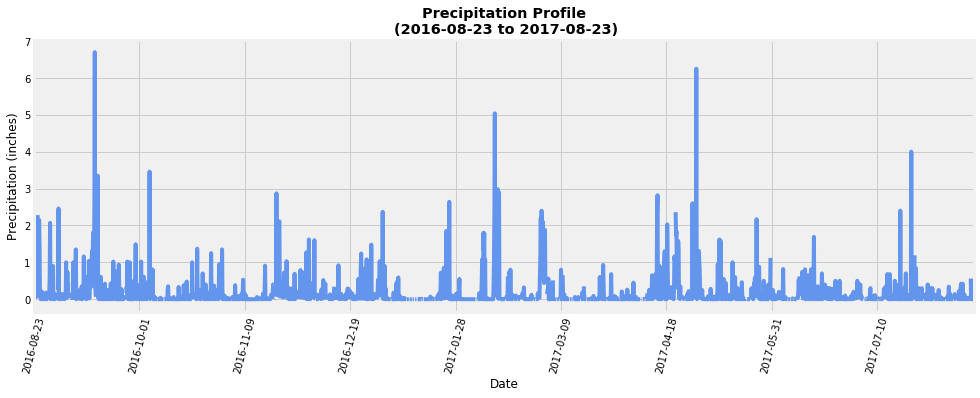

In [15]:
# Plot precipitation data
prcp_df.plot(y='prcp',
             figsize=(15,5),
             legend=False,
             color = 'cornflowerblue')

# Format plot
plt.xticks(rotation = 75)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title(f"Precipitation Profile\n ({start_date_fmt} to {latest_date['date']})",fontweight="bold")

# Display plot
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
statsSummary = prcp_df.describe()
statsSummary.rename(columns = {'prcp':"Precipitation (inches)"})

,Precipitation (inches)
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis


In [17]:
# Determine number of weather stations
noStations = (
                session
                .query(Measurement.station)
                .group_by(Measurement.station)
                .count()
              )

print(f"{noStations} different weather stations are used to make precipitation measurements")

9 different weather stations are used to make precipitation measurements


In [18]:
# List the stations and the number of weather observations made at each station (in descending order)
activeStations = ( 
               session
              .query(Measurement.station, Station.name, func.count(Measurement.station))
              .group_by(Measurement.station)
              .join(Station, Measurement.station == Station.station)
              .order_by(func.count(Measurement.station).desc())
              .all()
              )
activeStations

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [19]:
# Determine the most active station
activeStation = activeStations[0]
print(f"The most active weather station is {activeStation[0]}({activeStation[1]}) with {activeStation[2]} measurements made")

The most active weather station is USC00519281(WAIHEE 837.5, HI US) with 2772 measurements made


In [20]:
# Determine minimum, maximum, and average observed temperatures from most active weather station
activePrcp = ( 
                 session
                 .query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
                 .group_by(Measurement.station)
                 .filter_by(station = activeStation[0])
                 .all()
              )

# Print out the results
print(f'''{activeStation[0]} ({activeStation[1]}) recorded the following temperatures:
Minimum Temperature: {activePrcp[0][0]} deg F
Maximum Temperature: {activePrcp[0][1]} deg F
Average Temperature: {round(activePrcp[0][2],2)} deg F''')

USC00519281 (WAIHEE 837.5, HI US) recorded the following temperatures:
Minimum Temperature: 54.0 deg F
Maximum Temperature: 85.0 deg F
Average Temperature: 71.66 deg F


In [21]:
# Determine latest measurement taken by most active station
stationLast = (
                session
                .query(Measurement.date)
                .filter_by(station = activeStation[0])
                .order_by(Measurement.date.desc())
                .first()
                ._asdict()
                )

# Determine the start date for a year's worth query
stationLast_f = dt.datetime.strptime(stationLast['date'],'%Y-%m-%d')
stationStart = dt.date(stationLast_f.year -1,stationLast_f.month, stationLast_f.day)

# Format the start date
stationStart_fmt = f"{stationStart.year}-{'{:02d}'.format(stationStart.month)}-{'{:02d}'.format(stationStart.day)}"


In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
activeStationData = (
                        session
                        .query(Measurement.date, Measurement.tobs)
                        .filter_by(station = activeStation[0])
                        .filter(Measurement.date >= stationStart)
                        .filter(Measurement.date <= stationLast['date'])
                        .order_by(Measurement.date.asc())
                        .all()
)

# Save query as a dataframe
activeStationDate_df = (
                        pd
                        .DataFrame(activeStationData)
                        .set_index('date')
)

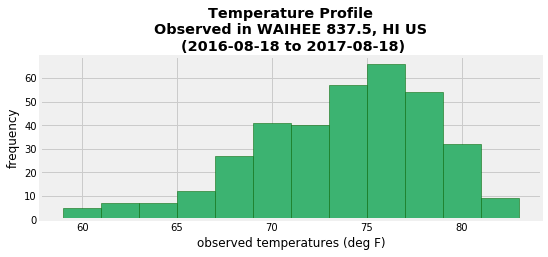

In [23]:
# Plot histogram of observed temperature readings from active weather station. Use 12 bins
(
    activeStationDate_df
    .plot
    .hist(y='tobs',
          bins=12,
          figsize=(8,3),
          legend=False,
          color ='mediumseagreen',
          edgecolor='darkgreen')
)

# Format plot
plt.xlabel("observed temperatures (deg F)")
plt.ylabel("frequency")
plt.title(f"Temperature Profile\nObserved in {activeStation[1]}\n ({stationStart_fmt} to {stationLast['date']})",fontweight="bold")

# Display plot
plt.show()

----
## Bonus Challenge Assignment

### Temperature Analysis I

In [24]:
# Ensure that there aren't any non-float values in the measurement database
check = session.query(Measurement.date, Measurement.tobs).all()

count=0
for entry in check:
    if type(entry.tobs) != float:
        count +=1
count

0

In [25]:
# Determine June and December Averages
junAvg = (session.query(func.avg(Measurement.tobs)).filter(Measurement.date.like('%-06-%')).all())
decAvg = (session.query(func.avg(Measurement.tobs)).filter(Measurement.date.like('%-12-%')).all())

# Print results
print(f"Average temperature in June:  {round(junAvg[0][0],3)} deg F")
print(f"Average temperature in December: {round(decAvg[0][0],3)} deg F")

Average temperature in June:  74.944 deg F
Average temperature in December: 71.042 deg F


#### Because weather data is taken from different weather stations and the number of weather observations differ between June and December (and stations), an indepenedent T-TEST is most appropriate. If data from all 9 weather stations were used everyday (without exception), then a paired t-test could have been considered.

In [26]:
# June and December temperature data sets
junTemps = (session.query(Measurement.tobs).filter(Measurement.date.like('%-06-%')).all())
decTemps = (session.query(Measurement.tobs).filter(Measurement.date.like('%-12-%')).all())

# Perform paired t-test
t_test= stats.ttest_ind(junTemps, decTemps)
t_test

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

In [27]:
if t_test[1][0] < 0.05:
    print(f"T-test returns a very small p-value ({t_test[1][0]})that is rounded down to {round(t_test[1][0],5)}")
    print(f"Conclusion: Difference between June mean & December mean is statistically significant")

T-test returns a very small p-value (3.9025129038616655e-191)that is rounded down to 0.0
Conclusion: Difference between June mean & December mean is statistically significant


### Temperature Analysis II

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Request user to input vacation dates
trip_startDate = input("When is your vacation starting? ('YYYY-MM-DD'): ")
trip_endDate = input("When is your vacation coming to an end? ('YYYY-MM-DD'): ")

# Calculate last year's date
trip_startDate_f = dt.datetime.strptime(trip_startDate,'%Y-%m-%d')
trip_endDate_f = dt.datetime.strptime(trip_endDate,'%Y-%m-%d')
prevYearStart = dt.date(trip_startDate_f.year -1,trip_startDate_f.month, trip_startDate_f.day)
prevYearEnd = dt.date(trip_endDate_f.year -1,trip_endDate_f.month, trip_endDate_f.day)


# Request last year's weather data
reqData = calc_temps(prevYearStart,prevYearEnd)

# If last year's data is not available, then go back enough years to get 
# valid data for the inputted dates

# Initialize variables
factor = 1

# While weather data is invalid, keep going back an extra year until valid seasonal data can be retrieved
while reqData[0][0] == None:
        factor +=1
        print(f"\nLast year's data was not found. Going back {factor} year(s)...")
        prevYearStart = dt.date(trip_startDate_f.year -factor,trip_startDate_f.month, trip_startDate_f.day)
        prevYearEnd = dt.date(trip_endDate_f.year -factor,trip_endDate_f.month, trip_endDate_f.day)
        reqData = calc_temps(prevYearStart,prevYearEnd)

# Format dates
prevYearStart_f = f"{prevYearStart.year}-{'{:02d}'.format(prevYearStart.month)}-{'{:02d}'.format(prevYearStart.day)}"
prevYearEnd_f = f"{prevYearEnd.year}-{'{:02d}'.format(prevYearEnd.month)}-{'{:02d}'.format(prevYearEnd.day)}"
minReqData = round(reqData[0][0],2)
avgReqData = round(reqData[0][1],2)
maxReqData = round(reqData[0][2],2)

# Print results to screen
print(f"\nFor a vacation starting on {trip_startDate}, ending on {trip_endDate}, the following data is available:")
print(f"Data from {factor} years ago, ({prevYearStart_f} to {prevYearEnd_f}):")
print(f'''Minimum Temperature: {minReqData} deg F
Maximum Temperature: {maxReqData} deg F
Average Temperature: {avgReqData} deg F''')

When is your vacation starting? ('YYYY-MM-DD'): 2020-07-29
When is your vacation coming to an end? ('YYYY-MM-DD'): 2020-08-12

Last year's data was not found. Going back 2 year(s)...

Last year's data was not found. Going back 3 year(s)...

For a vacation starting on 2020-07-29, ending on 2020-08-12, the following data is available:
Data from 3 years ago, (2017-07-29 to 2017-08-12):
Minimum Temperature: 71.0 deg F
Maximum Temperature: 84.0 deg F
Average Temperature: 79.19 deg F


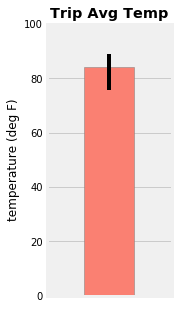

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = np.array([avgReqData-minReqData,maxReqData-avgReqData])

# Create bar plot with error bars
plt.figure(figsize=(2,5))
plt.bar(1,
        reqData[0][2],
        yerr=yerr.reshape(2,1),
        color="salmon",
        edgecolor="grey")

# Format bar graph
plt.title("Trip Avg Temp", fontweight='bold')
plt.ylabel('temperature (deg F)')
plt.xlim(0,2)
plt.ylim(0,100)
plt.xticks([])

# Display plot
plt.show()

### Daily Rainfall Average

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates 
# using the previous year's matching dates.
# Sort this in descending order by precipitation amount 
# and list the station, name, latitude, longitude, and elevation

# Query the total historical rainfall experienced during vacation days
# as measured by every weather station
rainfall = (
            session
            .query(Measurement.station, 
                   Station.name, 
                   Station.latitude,
                   Station.longitude,
                   Station.elevation,
                   func.sum(Measurement.prcp))
            .join(Station, Measurement.station == Station.station)
            .filter(Measurement.date >= prevYearStart)
            .filter(Measurement.date <= prevYearEnd)
            .group_by(Measurement.station)
            .order_by(func.sum(Measurement.prcp).desc())
            .all()
            )

# Convert query into dataframe
rainfall_df = pd.DataFrame(rainfall,columns=["Station","Station Name","Lat","Lon","Elv","Total Prcp"])  

# Display dataframe
rainfall_df


,Station,Station Name,Lat,Lon,Elv,Total Prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.66
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.34
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.29
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.06
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


### Daily Normals

In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# Calculate number of vacation days given previous' section inputs
vDays = (prevYearEnd - prevYearStart) + dt.timedelta(days=1)

# Use the start and end date to create a range of dates
delta_t = np.arange(1,vDays.days)
dates = [trip_startDate_f.strftime('%Y-%m-%d')]
for d in delta_t:
    dates.append((trip_startDate_f + dt.timedelta(days=int(d))).strftime('%Y-%m-%d'))


# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in dates:
    # Strip off the year and save a list of %m-%d strings
    timestring = date[-5:]
    temp = daily_normals(timestring)
    normals.append([temp [0][0],temp [0][1],temp [0][2]])

In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ["tmin","tavg","tmax"])
dates_df = pd.DataFrame(dates, columns = ["date"])

# Concatenate date and normals dataframes
trip_df = pd.concat([dates_df,normals_df], axis=1).set_index('date')
trip_df.index = trip_df.index.map(str)

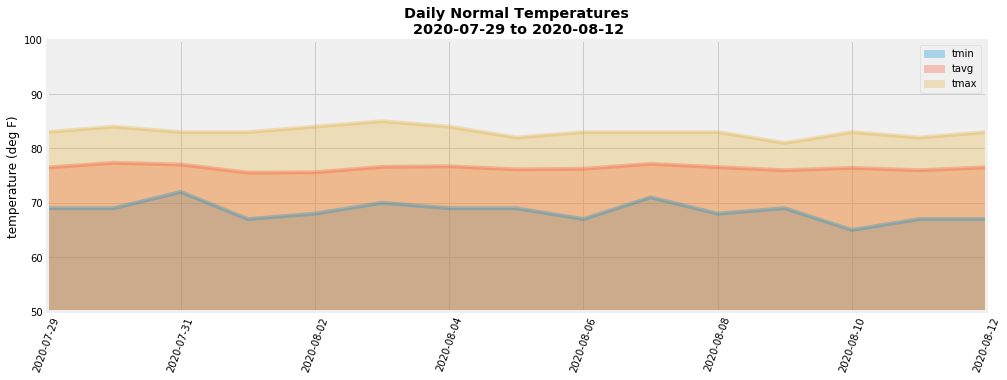

In [36]:
# Plot the daily normals as an area plot with `stacked=False`
(
    trip_df
    .plot
    .area(stacked=False,
          figsize=(15,5),
          alpha = 0.3)
)

# Format plot
plt.title(f"Daily Normal Temperatures\n {dates[0]} to {dates[len(dates)-1]}",fontweight="bold")
plt.xticks(rotation = 70)
plt.xlabel("")
plt.ylabel("temperature (deg F)")
plt.ylim(50,100)
plt.legend(loc="upper right")
# Display the plot
plt.show()